In [ ]:
# 💀 Сложное задание! 💀
# При помощи библиотеки gspread отправьте данные из предыдущего шага в Google SpreadSheet. Далее отправьте ссылку на получившийся файл в Google SpreadSheet (не забудьте открыть доступ по ссылке, это можно сделать вручную, когда данные уже зальются в таблицу) при помощи vk api себе в личку ВКонтакте. 

# ⭐️Задание со звёздочкой!⭐️
# Другой аналитик уже агрегировал часть данных из метрики, и вам нужно объединить усилия, чтобы получить финальный отчет. Прочитайте дополнительные данные из Google SpreadSheet, объедините вашу таблицу из предыдущего шага с таблицей аналитика и посчитайте количество визитов на человека (отношение visits к users) в разрезе по браузеру и значениям Robots/People.
# В ответе укажите, сколько визитов на уникального пользователя совершается ботами с браузера Google Chrome (округлите до целого)
# Вот так можно прочитать данные другого аналитика:

# from io import BytesIO
# import requests
# r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQWMsvBTVio9C7IOOxfFO9C15BRHyME-_ENHqBodDOjuiHwk9fCuF5hUVmDs497PZOqPYK3exdSikOK/pub?gid=1006633900&single=true&output=csv')
# data = r.content

# df = pd.read_csv(BytesIO(data))

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode
import json

import vk_api

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

In [10]:
# Create a list of the dates we need
dates = ['2023-02-14', '2023-02-15', '2023-02-16']

# Base url to service
url = 'https://api-metrika.yandex.net/stat/v1/data?'


# Create a dataframe
df = pd.DataFrame()

for date in dates:
    
    # &-separated parameters of query in a form of name=value, taken from the metrica site
    visits = f"metrics=ym:s:visits&dimensions=ym:s:date&filters=ym:s:date=='{date}'&&dimensions=ym:s:isRobot&id=44147844"
    
    visits_url = url + visits
    
    # Get json of response
    responce = requests.get(visits_url)
    
    # Parse our json into a dictionary
    json_data = responce.json()
    
    for record in json_data['data']:
        
        # Extract data
        intermediate_data = record['dimensions']
        visits = record['metrics'][0]
        date = intermediate_data[0]['name']
        robot_type = intermediate_data[1]['name']      

        # Create row and concat it to df
        row = [[date, robot_type, visits]]
        df = pd.concat([df, pd.DataFrame(row)], ignore_index=True)     

In [11]:
# Rename columns
df.columns = ['date', 'type', 'visits']

In [12]:
df

,date,type,visits
0,2023-02-14,People,482.0
1,2023-02-14,Robots,17.0
2,2023-02-15,People,512.0
3,2023-02-15,Robots,36.0
4,2023-02-16,People,492.0
5,2023-02-16,Robots,29.0


In [73]:
# Load data into part_1.csv file
df.to_csv('part_1.csv')

<Axes: xlabel='date', ylabel='visits'>

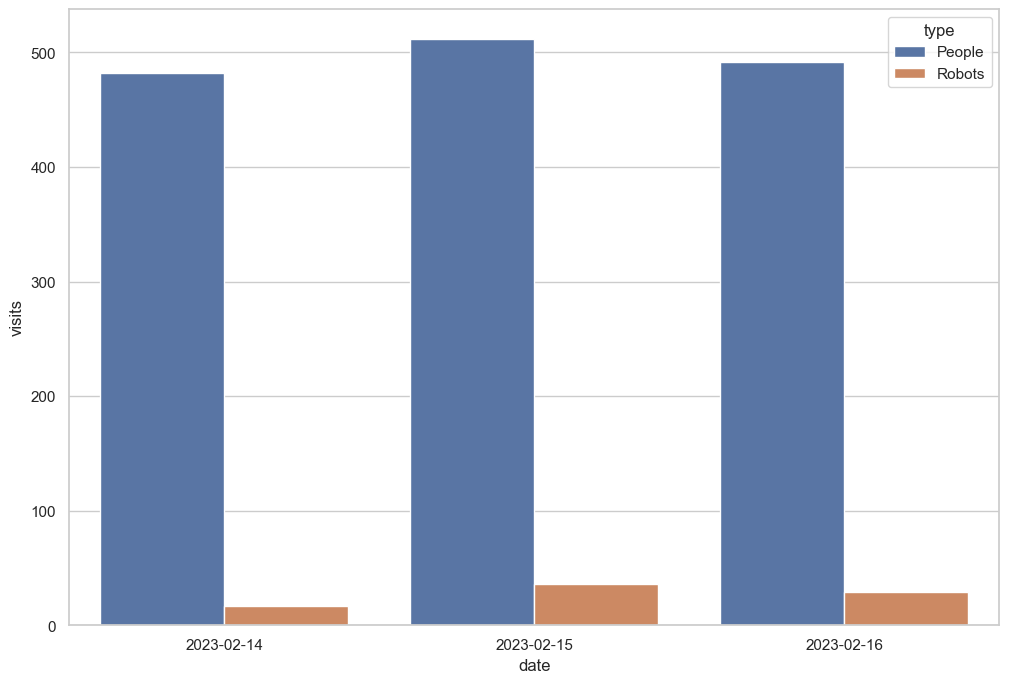

In [13]:
# Build a barplot
sns.set(style='whitegrid',
        rc={'figure.figsize':(12,8)})
sns.barplot(data=df, 
            x='date', 
            hue='type',
            y='visits')

In [14]:
# Reading data from Yandex.Metrica for 2023-02-16 and writing it to a dataframe

# Base url to service
url = 'https://api-metrika.yandex.net/stat/v1/data?'


# Create a dataframe
browser_df = pd.DataFrame()

    
# Parameters of query
params = {'metrics': 'ym:s:visits',
          'dimensions': ['ym:s:date', 'ym:s:isRobot', 'ym:s:browser'],
          'filters': "ym:s:date=='2023-02-16'",
          'id': 44147844}

visits = urlencode(params, doseq=True)

visits_url = url + visits

# Get json of response
responce = requests.get(visits_url)

# Parse our json into a dictionary
json_data = responce.json()
    
for record in json_data['data']:

    # Extract data
    intermediate_data = record['dimensions']
    visits = record['metrics'][0]
    date = intermediate_data[0]['name']
    robot_type = intermediate_data[1]['name'] 
    browser_type = intermediate_data[2]['name'] 

    # Create row and concat it to df
    row = [[date, robot_type, browser_type, visits]]
    browser_df = pd.concat([browser_df, pd.DataFrame(row)], ignore_index=True)

In [15]:
# Rename columns
browser_df.columns = ['date', 'type', 'browser','visits']

In [16]:
# Load data into part_2.csv file
browser_df.to_csv('part_2.csv')

In [17]:
browser_df.head()

,date,type,browser,visits
0,2023-02-16,People,Google Chrome,222.0
1,2023-02-16,People,Chrome Mobile,124.0
2,2023-02-16,People,Yandex Browser,37.0
3,2023-02-16,People,Safari,32.0
4,2023-02-16,People,Edge,29.0


In [18]:
# Determine the number of visitors for each browser
visits_vs_browser = browser_df.groupby('browser').agg({'visits':'sum'})

In [19]:
# Find the percentage of site visits from the Google Chrome browser to the total number and round up to integers
round(visits_vs_browser.loc['Google Chrome'] / visits_vs_browser.sum() * 100)[0]

44.0

In [20]:
# Determine the number of visitors for each browser by removing the index
visits_vs_browser = browser_df.groupby('browser', as_index=False).agg({'visits':'sum'})


In [21]:
# Merge our dataframe with with a column of the total number of visitors for each browser and rename columns
full_df = browser_df.merge(visits_vs_browser, 
                             on='browser',
                             suffixes=('_type', '_all'))

In [22]:
# Determine the number of visits of each type to the total number of browsers
full_df['ratio'] = full_df.visits_type / full_df.visits_all

In [23]:
full_df.head()

,date,type,browser,visits_type,visits_all,ratio
0,2023-02-16,People,Google Chrome,222.0,230.0,0.965217
1,2023-02-16,Robots,Google Chrome,8.0,230.0,0.034783
2,2023-02-16,People,Chrome Mobile,124.0,131.0,0.946565
3,2023-02-16,Robots,Chrome Mobile,7.0,131.0,0.053435
4,2023-02-16,People,Yandex Browser,37.0,40.0,0.925000


In [76]:
# Load data into part_3.csv file
full_df.to_csv('part_3.csv')

In [24]:
# Determine which browser has the smallest share of site visits by bots from the total number of visits
full_df.query('type == "Robots"').nsmallest(1, columns='ratio')

,date,type,browser,visits_type,visits_all,ratio
1,2023-02-16,Robots,Google Chrome,8.0,230.0,0.034783


In [25]:
# Our data is unique, so you can not group it and use a dataframe with 3 parts, find the percentage ratio of the share of visits to the site from each source and enter this data in a new column
browser_df['percent'] = browser_df.visits / browser_df.visits.sum() * 100

In [26]:
browser_df.head()

,date,type,browser,visits,percent
0,2023-02-16,People,Google Chrome,222.0,42.610365
1,2023-02-16,People,Chrome Mobile,124.0,23.800384
2,2023-02-16,People,Yandex Browser,37.0,7.101727
3,2023-02-16,People,Safari,32.0,6.142035
4,2023-02-16,People,Edge,29.0,5.566219


In [27]:
# Percentage of site opens by browser Safari people(not bots) accurate to 1 decimal place
round(browser_df.query('type == "People" and browser == "Safari"'), 1)

,date,type,browser,visits,percent
3,2023-02-16,People,Safari,32.0,6.1


In [108]:
# Load data into part_4.csv file
browser_df.to_csv('part_4.csv')

In [86]:
# 💀 Сложное задание! 💀
# При помощи библиотеки gspread отправьте данные из предыдущего шага в Google SpreadSheet. Далее отправьте ссылку на получившийся файл в Google SpreadSheet (не забудьте открыть доступ по ссылке, это можно сделать вручную, когда данные уже зальются в таблицу) при помощи vk api себе в личку ВКонтакте. 

In [46]:
# Pass a set of permissions to our script
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# email
my_mail = 'samgsm333@gmail.com'


# key with access
path_to_credentials = '/Users/samgsm/token/samgsm.json'


# Authorization
credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credentials, scope)
gs = gspread.authorize(credentials)

In [47]:
# New table name
table_name = 'pet_project'

In [48]:
# Create a table
gs.create(table_name)

<Spreadsheet 'pet_project' id:1WFk9jCeyjV7MsEgd2byOi7Lg28zr0oUORgbHn_OXpE8>

In [49]:
# Open the table
table = gs.open(table_name)

In [50]:
# Share the table
table.share(my_mail, perm_type='user', role='writer')

<Response [200]>

In [51]:
# List name
sheet_name = 'list1'

In [52]:
# Drop index
browser_df.reset_index(drop=True, inplace=True)

In [53]:
# Load dataframe into table
d2g.upload(browser_df, 
           table_name, 
           sheet_name, 
           credentials=credentials,
           row_names=True)

<Worksheet 'list1' id:108598916>

In [ ]:
#VK

In [54]:
# Go to the file with the token
with open('/Users/samgsm/token/vk_token.json') as src:
    credentials = json.load(src)

In [55]:
# Assigning a token to a variable
token = credentials['token']

In [56]:
# Create a session
chat_id = 1
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

In [57]:
link = 'https://docs.google.com/spreadsheets/d/1WFk9jCeyjV7MsEgd2byOi7Lg28zr0oUORgbHn_OXpE8/edit#gid=108598916'

In [59]:
my_id = 218706183



path = '/Users/samgsm/Project_7-master/part_4.csv'


file_name = 'top_ctr_data.csv'


upload_url = vk.docs.getMessagesUploadServer(peer_id=my_id)["upload_url"]

ApiError: [901] Can't send messages for users without permission

In [60]:
with open(path, 'rb') as f:

    file = {'file': (file_name, f)}


    response = requests.post(upload_url, files=file)

NameError: name 'upload_url' is not defined

In [ ]:
json_data = json.loads(response.text)
saved_file = vk.docs.save(file=json_data['file'], title=file_name)

In [ ]:

attachment = 'doc{}_{}'.format(saved_file['doc']['owner_id'], saved_file['doc']['id'])

In [ ]:
vk.messages.send(chat_id=chat_id, 
                 random_id=np.random.randint(0, 2**31), 
                 message="Hello",
                 attachment=attachment)
